Saving photo.jpeg to photo (2).jpeg
1/1 [==============================] - 0s 159ms/step


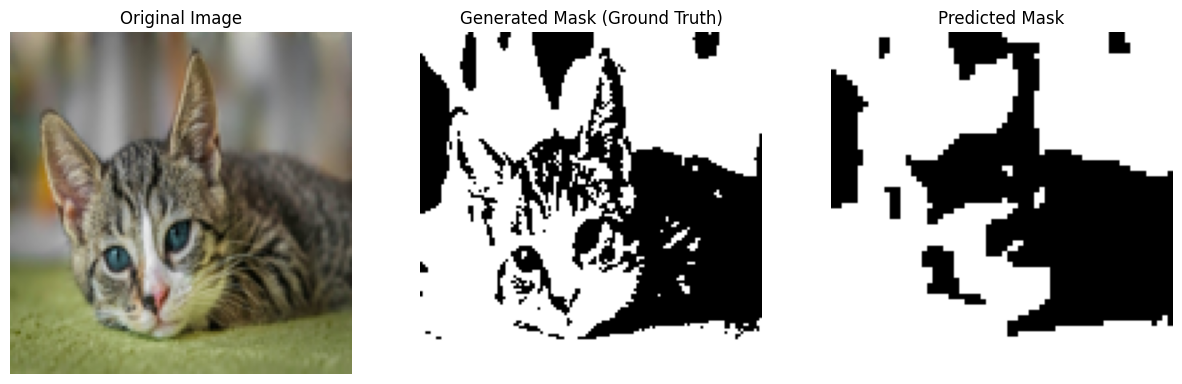

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from google.colab import files
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model

# Upload an image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Read and preprocess the image
image = Image.open(image_path).convert('RGB')
image = image.resize((128, 128))  # Resize to 128x128
image_array = np.array(image) / 255.0  # Normalize to [0,1]

# Convert image to uint8 before processing
image_array_uint8 = (image_array * 255).astype(np.uint8)

# Generate synthetic mask using thresholding
gray = cv2.cvtColor(image_array_uint8, cv2.COLOR_RGB2GRAY)
_, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask = mask.astype(np.float32) / 255.0  # Convert to binary mask [0,1]
mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

# Define the CNN model
def build_segmentation_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Decoder
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile the model
model = build_segmentation_model((128, 128, 3))
model.compile(optimizer='adam', loss='binary_crossentropy')

# Prepare data for training
X = np.expand_dims(image_array, axis=0)  # Add batch dimension
y = np.expand_dims(mask, axis=0)

# Train the model
history = model.fit(X, y, epochs=50, verbose=0)

# Predict the mask
predicted_mask = model.predict(X)[0]

# Threshold the prediction
predicted_mask_thresholded = (predicted_mask > 0.5).astype(np.float32)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_array)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Generated Mask (Ground Truth)')
plt.imshow(mask.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(predicted_mask_thresholded.squeeze(), cmap='gray')
plt.axis('off')

plt.show()